In [1]:
import os
import re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
! kaggle competitions download -c cassava-leaf-disease-classification



  0%|          | 0.00/5.76G [00:00<?, ?B/s]
  0%|          | 1.00M/5.76G [00:01<1:44:56, 982kB/s]
  0%|          | 2.00M/5.76G [00:01<55:03, 1.87MB/s] 
  0%|          | 3.00M/5.76G [00:01<35:38, 2.89MB/s]
  0%|          | 4.00M/5.76G [00:01<25:45, 4.00MB/s]
  0%|          | 5.00M/5.76G [00:01<20:20, 5.06MB/s]
  0%|          | 7.00M/5.76G [00:01<15:07, 6.81MB/s]
  0%|          | 8.00M/5.76G [00:01<13:47, 7.47MB/s]
  0%|          | 10.0M/5.76G [00:02<12:24, 8.29MB/s]
  0%|          | 11.0M/5.76G [00:02<12:16, 8.39MB/s]
  0%|          | 12.0M/5.76G [00:02<11:53, 8.65MB/s]
  0%|          | 13.0M/5.76G [00:02<11:46, 8.73MB/s]
  0%|          | 14.0M/5.76G [00:02<11:39, 8.82MB/s]
  0%|          | 15.0M/5.76G [00:02<12:11, 8.43MB/s]
  0%|          | 16.0M/5.76G [00:02<11:46, 8.73MB/s]
  0%|          | 18.0M/5.76G [00:03<10:59, 9.35MB/s]
  0%|          | 19.0M/5.76G [00:03<11:00, 9.34MB/s]
  0%|          | 20.0M/5.76G [00:03<11:11, 9.17MB/s]
  0%|          | 21.0M/5.76G [00:03<11:04, 9.27MB/s]


 67%|██████▋   | 3.87G/5.76G [08:05<04:39, 7.25MB/s]
 67%|██████▋   | 3.87G/5.76G [08:05<04:15, 7.94MB/s]
 67%|██████▋   | 3.87G/5.76G [08:05<04:06, 8.23MB/s]
 67%|██████▋   | 3.87G/5.76G [08:06<04:01, 8.38MB/s]
 67%|██████▋   | 3.88G/5.76G [08:06<03:54, 8.64MB/s]
 67%|██████▋   | 3.88G/5.76G [08:06<03:49, 8.81MB/s]
 67%|██████▋   | 3.88G/5.76G [08:06<03:54, 8.64MB/s]
 67%|██████▋   | 3.88G/5.76G [08:06<04:18, 7.82MB/s]
 67%|██████▋   | 3.88G/5.76G [08:06<04:04, 8.25MB/s]
 67%|██████▋   | 3.88G/5.76G [08:06<03:59, 8.45MB/s]
 67%|██████▋   | 3.88G/5.76G [08:06<03:54, 8.59MB/s]
 67%|██████▋   | 3.88G/5.76G [08:07<03:53, 8.66MB/s]
 67%|██████▋   | 3.88G/5.76G [08:07<03:46, 8.89MB/s]
 67%|██████▋   | 3.88G/5.76G [08:07<03:40, 9.16MB/s]
 67%|██████▋   | 3.88G/5.76G [08:07<03:36, 9.32MB/s]
 67%|██████▋   | 3.89G/5.76G [08:07<03:39, 9.16MB/s]
 67%|██████▋   | 3.89G/5.76G [08:07<03:46, 8.87MB/s]
 67%|██████▋   | 3.89G/5.76G [08:07<03:46, 8.87MB/s]
 68%|██████▊   | 3.89G/5.76G [08:07<03:39, 9.

In [6]:
import zipfile
import os

# Path to your downloaded ZIP file
zip_file_path = "cassava-leaf-disease-classification.zip"
extract_dir = "./cassava-leaf-disease"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete!")


Extraction complete!


In [7]:
label_to_disease = pd.read_json('./cassava-leaf-disease/label_num_to_disease_map.json', typ='series')

## Data Prep

In [14]:
train_csv = pd.read_csv('./cassava-leaf-disease/train.csv')

train_csv['disease'] = train_csv['label'].map(label_to_disease)
train_csv['path'] = './cassava-leaf-disease/train_images/' + train_csv['image_id']


In [12]:
print(train_csv.isnull().sum())


image_id    0
label       0
dtype: int64


In [15]:
from sklearn.preprocessing import LabelEncoder
train_csv['label_encoded'] = LabelEncoder().fit_transform(train_csv['disease'])


Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


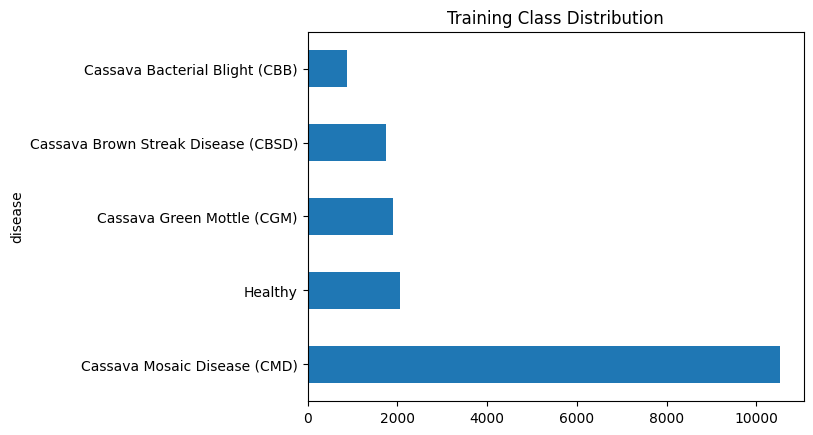

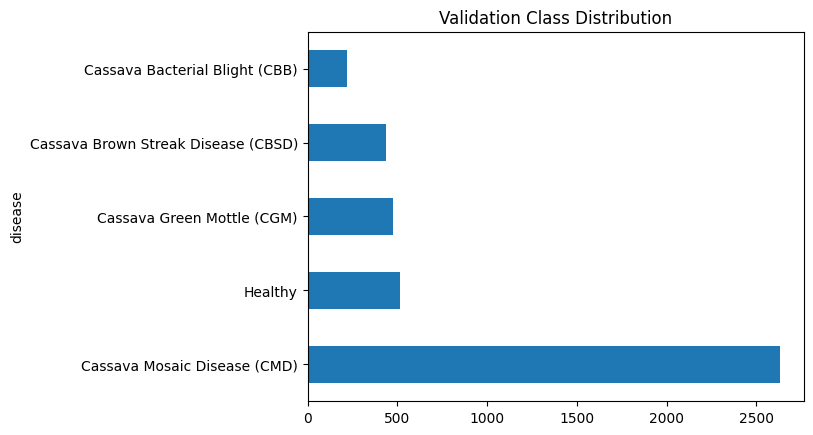

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Convert 'disease' and 'label' columns to string type
train_csv['disease'] = train_csv['disease'].astype('str')
train_csv['label'] = train_csv['label'].astype('str')

# Split the data into train and validation sets with stratified sampling
train, valid = train_test_split(train_csv, test_size=0.2, stratify=train_csv['label'])

# Data augmentation and preprocessing for training
datagen_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator for the training set
train_generator = datagen_aug.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='disease',
    target_size=(320, 320),  # Resize images to 320x320
    batch_size=32,
    class_mode='categorical',  # Assuming multi-class classification
    shuffle=True
)

# Generator for the validation set
valid_generator = datagen_aug.flow_from_dataframe(
    dataframe=valid,
    x_col='path',
    y_col='disease',
    target_size=(320, 320),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Plot the class distribution for the training set
train['disease'].value_counts().plot(kind='barh')
plt.title('Training Class Distribution')
plt.show()

# Plot the class distribution for the validation set
valid['disease'].value_counts().plot(kind='barh')
plt.title('Validation Class Distribution')
plt.show()


## Import models

In [9]:
import tensorflow_hub as hub
classifier = hub.KerasLayer('https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2')